# Imports

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import collections

# Degree Network

Create a network with a desired degree - code start taken from lecture and ChatGPT was used to help create a working version. Link to chat: https://chat.openai.com/share/6d50a46c-cb21-4e5d-9173-7e5b37c031d3


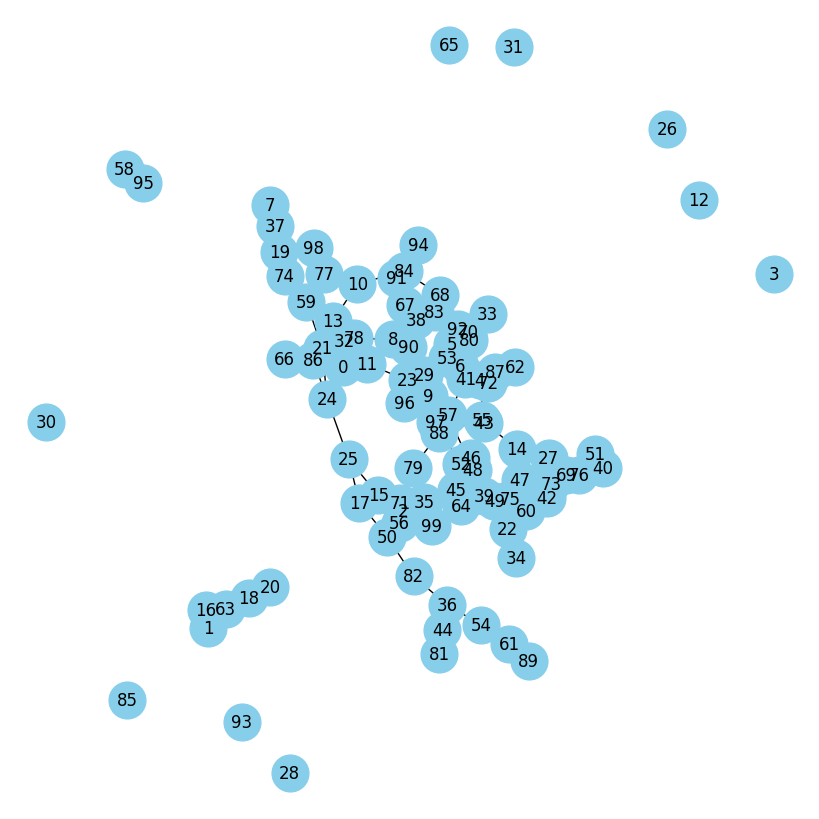

In [2]:


def configuration_A(S):
    """Configuration model with degree sequence S"""
    stubs = []
    for i in range(len(S)):
        for j in range(S[i]):
            stubs.append(i)
    n = nx.Graph()
    n.add_nodes_from(range(len(S)))  # Ensure the graph has len(S) nodes
    while len(stubs) > 1:  # Need at least 2 stubs to form an edge
        v, w = random.sample(stubs, 2)
        if v != w:  # Avoid self-loops
            n.add_edge(v, w)
            # Remove v, w from stubs
            stubs.remove(v)
            stubs.remove(w)
    return n

def configuration_B(n, P):
    """Configuration model with degree distribution P"""
    S = [1]
    while not nx.is_valid_degree_sequence_erdos_gallai(S):
        S = random.choices(population=range(len(P)), weights=P, k=n)
    return configuration_A(S)
def plot_graph(G):
    """Plot the given graph G using matplotlib"""
    plt.figure(figsize=(8, 8))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
    plt.show()


def plot_degree_distribution(G, P):
    """Plot the degree distribution of graph G and compare it with distribution P"""
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # Also plot the theoretical distribution P for comparison
    theoretical_degrees = range(len(P))
    plt.plot(theoretical_degrees, [p*n for p in P], 'r-', label='Theoretical distribution')
    plt.legend()
    plt.show()



n = 100  # Number of nodes
P = [0.1, 0.2, 0.3, 0.4]  # Example distribution for demonstration


graph = configuration_B(n, P)
plot_graph(graph)

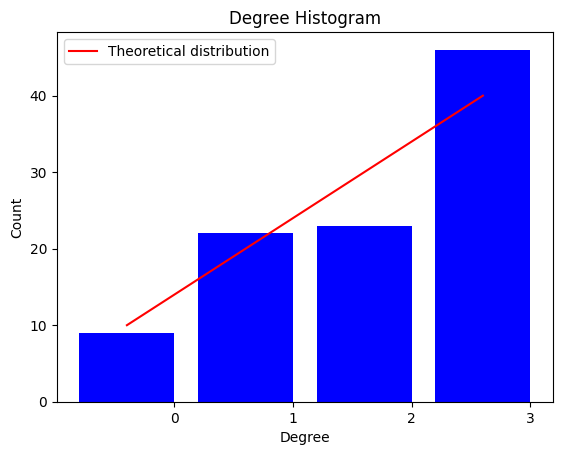

In [3]:
plot_degree_distribution(graph, P)

# Model2-3

Fits clustering and check with r and d

In [4]:
import networkx as nx
import random

def find_largest_component(G):
    largest_cc = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_cc).copy()

def model3(G, c_current, cluster, allowed_error, nodes_per_round):
    c_steps = [c_current]
    cluster_bound = [cluster - allowed_error, cluster + allowed_error]
    i = 0

    while c_current < cluster_bound[0] or c_current > cluster_bound[1]:
        i += 1
        nodes = list(G.nodes())
        random.shuffle(nodes)

        for node in nodes:
            if node not in G:
                continue

            current_links = set(G[node])

            if current_links:
                link_to_remove = random.choice(list(current_links))
                G.remove_edge(node, link_to_remove)

                if node not in G or len(G[node]) == 0:
                    G = find_largest_component(G)
                    if node not in G:
                        continue

                target_degree = G.degree(node)

                # Collect possible new links from direct neighbors and neighbors of neighbors
                possible_new_links = set()
                for neighbor in current_links:
                    if neighbor in G:
                        second_neighbors = set(G[neighbor]) - {node}
                        possible_new_links.update(second_neighbors)

                possible_new_links = [n for n in possible_new_links if n not in current_links and G.degree(n) == target_degree]

                if not possible_new_links:
                    G = find_largest_component(G)
                    possible_new_links = [n for n in G.nodes() if n not in current_links and n != node and G.degree(n) == target_degree]

                if possible_new_links:
                    c_possible = []
                    for possible in possible_new_links:
                        G.add_edge(node, possible)
                        new_clustering = nx.average_clustering(G)
                        c_possible.append(new_clustering)
                        G.remove_edge(node, possible)

                    if c_possible:
                        best_node = possible_new_links[c_possible.index(max(c_possible))]
                        G.add_edge(node, best_node)

        c_current = nx.average_clustering(G)
        c_steps.append(c_current)

    return G, i, c_steps

# Example usage
# G = nx.fast_gnp_random_graph(100, 0.05)
# initial_clustering = nx.average_clustering(G)
# G, iterations, clustering_changes = model3(G, initial_clustering, 0.6, 0.02, 5)

In [5]:
# check how good the model is


def analyze_graph(G):
    # Check if the graph is connected; this is required to compute the diameter
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print(f"Diameter of the graph: {diameter}")
    else:
        print("Graph is not connected; diameter of the giant component will be calculated.")
        # Find the largest connected component (giant component)
        giant_component = max(nx.connected_components(G), key=len)
        G_giant = G.subgraph(giant_component).copy()

        # Diameter of the giant component
        diameter = nx.diameter(G_giant)
        print(f"Diameter of the giant component: {diameter}")


    # Average Clustering Coefficient
    avg_clustering = nx.average_clustering(G)
    print(f"Average Clustering Coefficient: {avg_clustering}")

    # Degree Distribution
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = np.bincount(degrees)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_counts)), degree_counts, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()


In [6]:
import pandas as pd
# Meet's stuff
Sydney = pd.read_csv("Sydney.csv")
SiouxFalls = pd.read_csv("SiouxFalls.csv")
Anaheim = pd.read_csv("Anaheim.csv")
BerlinFriedrichshain = pd.read_csv("Berlin-Friedrichshain.csv")
BerlinMitteCenter = pd.read_csv("Berlin-Mitte-Center.csv")
Barcelona = pd.read_csv("Barcelona.csv")
EasternMassachusetts = pd.read_csv("Eastern-Massachusetts.csv")
Winnipeg = pd.read_csv("Winnipeg.csv")

In [7]:
ana_net = bar_net = bf_net = bmc_net = em_net = sioux_net = syd_net = win_net = nx.Graph()

places = [Anaheim, Barcelona, BerlinFriedrichshain, BerlinMitteCenter, EasternMassachusetts, SiouxFalls, Sydney, Winnipeg]
graphs = [ana_net, bar_net, bf_net, bmc_net, em_net, sioux_net, syd_net, win_net]

for i in range(len(places)):
  for idx, row in places[i].iterrows():
    graphs[i].add_edge(row['init_node'], row['term_node'], **row.drop(['init_node', 'term_node']).to_dict())

In [11]:
# get a degree distribution from Eastern Massachusetts
em_degrees = [em_net.degree(n) for n in em_net.nodes()]
em_degree_counts = np.bincount(em_degrees)

In [12]:
# make that random model with that
em_graph = configuration_B(74, em_degree_counts)

In [13]:
em_graph_avg = nx.average_clustering(em_graph)

In [14]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2869
em_model, em_i, em_c_steps = model3(em_graph, em_graph_avg, c, c * 0.1, 5)

In [15]:
em_model

In [16]:
em_i

2

In [17]:
em_c_steps

[0.04163254163254163, 0.13636363636363638, 0.29279279279279286]

Diameter of the graph: 14
Average Clustering Coefficient: 0.29279279279279286


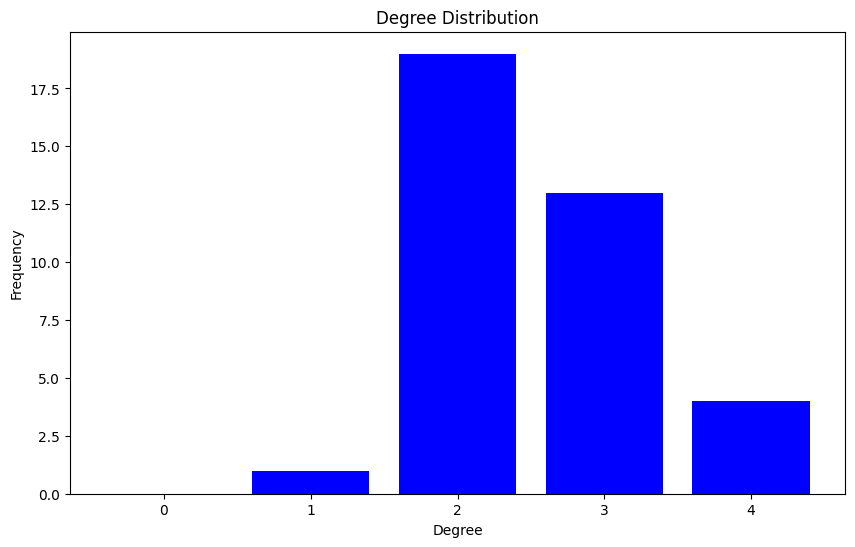

In [18]:
# compare calculated d and r values with actual values
analyze_graph(em_model)

In [19]:
nx.degree_assortativity_coefficient(em_model)

0.42165709598031087

In [29]:
# get a degree distribution from Sioux Falls
sioux_degrees = [sioux_net.degree(n) for n in sioux_net.nodes()]
sioux_degree_counts = np.bincount(sioux_degrees)

In [30]:
# make that random model with that
sioux_graph = configuration_B(24, sioux_degree_counts)

In [31]:
sioux_graph_avg = nx.average_clustering(sioux_graph)

In [32]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0528
sioux_model, sioux_i, sioux_c_steps = model3(sioux_graph, sioux_graph_avg, c, c * 0.1, 5)

: 

In [ ]:
sioux_model

In [ ]:
sioux_i

In [ ]:
sioux_c_steps

In [ ]:
# compare calculated d and r values with actual values
analyze_graph(sioux_model)

In [ ]:
nx.degree_assortativity_coefficient(sioux_model)

In [9]:
# get a degree distribution from Barcelona
bar_degrees = [bar_net.degree(n) for n in bar_net.nodes()]
bar_degree_counts = np.bincount(bar_degrees)

In [10]:
# make that random model with that
bar_graph = configuration_B(1020, bar_degree_counts)

In [11]:
bar_graph_avg = nx.average_clustering(bar_graph)

In [12]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0902
bar_model, bar_i, bar_c_steps = model3(bar_graph, bar_graph_avg, c, c * 0.1, 5)

In [13]:
bar_model

In [14]:
bar_i

15

In [15]:
bar_c_steps

[0.0029944439232364927,
 0.1532740597668454,
 0.1467014890298873,
 0.15441660644021515,
 0.1441943900848012,
 0.139101697461319,
 0.17460952380952383,
 0.19301587301587309,
 0.16187363834422655,
 0.15505050505050508,
 0.18333333333333335,
 0.12807017543859653,
 0.13852813852813856,
 0.1484375,
 0.10869565217391307,
 0.09444444444444446]

Diameter of the graph: 9
Average Clustering Coefficient: 0.09444444444444446


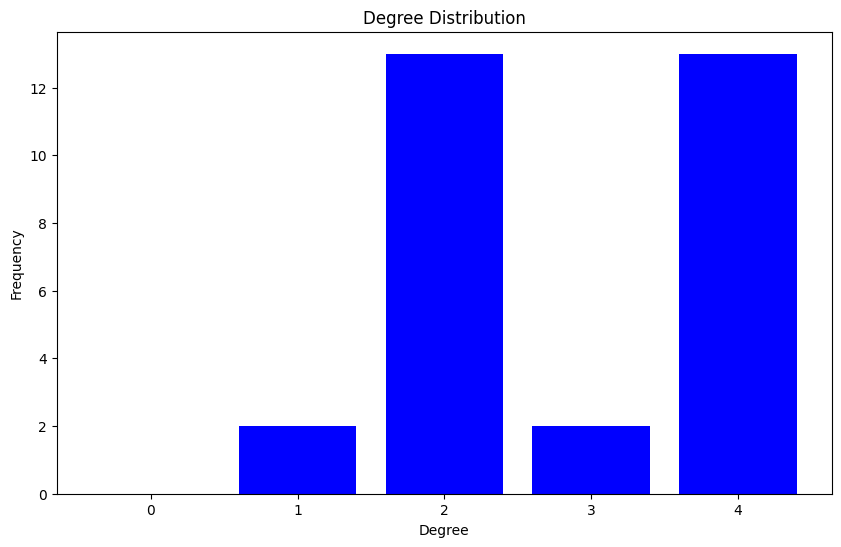

In [16]:
# compare calculated d and r values with actual values
analyze_graph(bar_model)

In [17]:
nx.degree_assortativity_coefficient(bar_model)

0.6018518518518514

In [ ]:
# get a degree distribution from Sydney
syd_degrees = [syd_net.degree(n) for n in syd_net.nodes()]
syd_degree_counts = np.bincount(syd_degrees)

In [ ]:
# make that random model with that
syd_graph = configuration_B(33837, syd_degree_counts)

In [ ]:
syd_graph_avg = nx.average_clustering(syd_graph)

In [ ]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0074
syd_model, syd_i, syd_c_steps = model3(syd_graph, syd_graph_avg, c, c * 0.1, 5)

KeyboardInterrupt: 

In [ ]:
syd_model

In [ ]:
syd_i

In [ ]:
syd_c_steps

In [ ]:
# compare calculated d and r values with actual values
analyze_graph(syd_model)

In [ ]:
nx.degree_assortativity_coefficient(syd_model)

In [22]:
# get a degree distribution from Winnipeg
win_degrees = [win_net.degree(n) for n in win_net.nodes()]
win_degree_counts = np.bincount(win_degrees)

In [23]:
# make that random model with that
win_graph = configuration_B(1052, win_degree_counts)

In [24]:
win_graph_avg = nx.average_clustering(win_graph)

In [25]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1045
win_model, win_i, win_c_steps = model3(win_graph, win_graph_avg, c, c * 0.1, 5)

In [26]:
win_model

In [27]:
win_i

11

In [28]:
win_c_steps

[0.0024918522542096686,
 0.16170652500495433,
 0.14947794073269333,
 0.13068078942603667,
 0.14567266495287068,
 0.15591397849462374,
 0.1213953488372093,
 0.2403892944038928,
 0.24352941176470588,
 0.261574074074074,
 0.18434343434343436,
 0.10869565217391304]

Diameter of the graph: 14
Average Clustering Coefficient: 0.10869565217391304


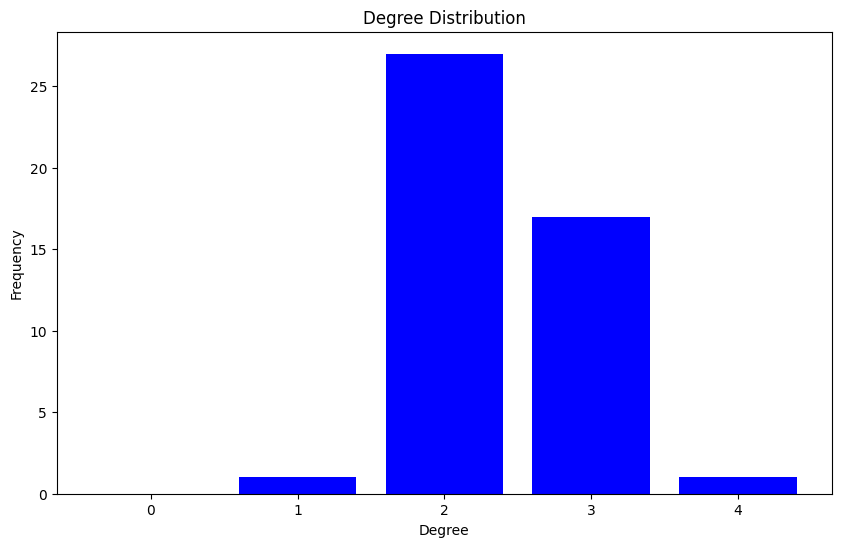

In [29]:
# compare calculated d and r values with actual values
analyze_graph(win_model)

In [30]:
nx.degree_assortativity_coefficient(win_model)

0.14480077745383838

In [31]:
# get a degree distribution from Anaheim
ana_degrees = [ana_net.degree(n) for n in ana_net.nodes()]
ana_degree_counts = np.bincount(ana_degrees)

In [32]:
# make that random model with that
ana_graph = configuration_B(416, ana_degree_counts)

In [33]:
ana_graph_avg = nx.average_clustering(ana_graph)

In [34]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1076
ana_model, ana_i, ana_c_steps = model3(ana_graph, ana_graph_avg, c, c * 0.1, 5)

In [35]:
ana_model

In [36]:
ana_i

16

In [37]:
ana_c_steps

[0.014558825255940643,
 0.2108946608946609,
 0.17597845395679337,
 0.13830687830687827,
 0.14522417153996095,
 0.16637426900584798,
 0.20326797385620907,
 0.20284552845528456,
 0.2518518518518519,
 0.33333333333333337,
 0.13333333333333333,
 0.057471264367816084,
 0.03571428571428571,
 0.20512820512820512,
 0.12,
 0.2222222222222222,
 0.1111111111111111]

Diameter of the graph: 9
Average Clustering Coefficient: 0.1111111111111111


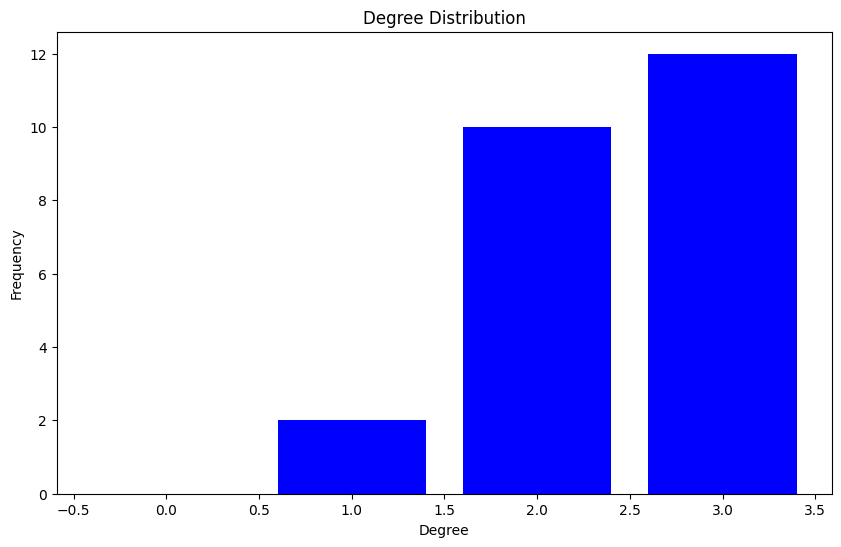

In [38]:
# compare calculated d and r values with actual values
analyze_graph(ana_model)

In [39]:
nx.degree_assortativity_coefficient(ana_model)

-0.10687022900763106

In [17]:
# get a degree distribution from BerlinFriedrichshain
bf_degrees = [bf_net.degree(n) for n in bf_net.nodes()]
bf_degree_counts = np.bincount(bf_degrees)

In [18]:
# make that random model with that
bf_graph = configuration_B(224, bf_degree_counts)

In [19]:
bf_graph_avg = nx.average_clustering(bf_graph)

In [20]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1915
bf_model, bf_i, bf_c_steps = model3(bf_graph, bf_graph_avg, c, c * 0.1, 5)

In [21]:
bf_model

In [22]:
bf_i

1

In [23]:
bf_c_steps

[0.009729853479853478, 0.1915973185390661]

Diameter of the graph: 23
Average Clustering Coefficient: 0.1915973185390661


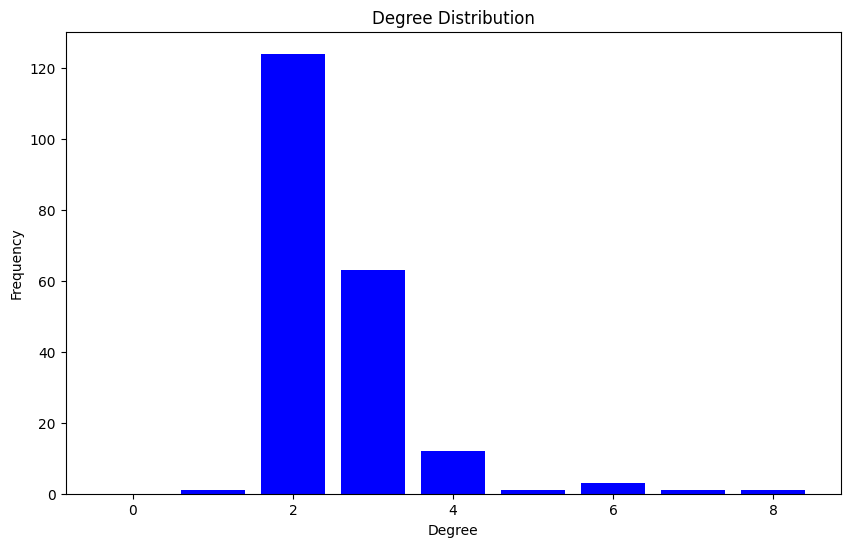

In [24]:
# compare calculated d and r values with actual values
analyze_graph(bf_model)

In [25]:
nx.degree_assortativity_coefficient(bf_model)

0.20473980678866358

In [8]:
# get a degree distribution from Berlin-Mitte-Center
bmc_degrees = [bmc_net.degree(n) for n in bmc_net.nodes()]
bmc_degree_counts = np.bincount(bmc_degrees)

In [9]:
# make that random model with that
bmc_graph = configuration_B(398, bmc_degree_counts)

In [10]:
bmc_graph_avg = nx.average_clustering(bmc_graph)

In [11]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2048
bmc_model, bmc_i, bmc_c_steps = model3(bmc_graph, bmc_graph_avg, c, c * 0.1, 5)

In [12]:
bmc_model

In [13]:
bmc_i

3

In [14]:
bmc_c_steps

[0.010860460691854501,
 0.1432546563336755,
 0.12553146258503406,
 0.18682078640584873]

Diameter of the graph: 24
Average Clustering Coefficient: 0.18682078640584873


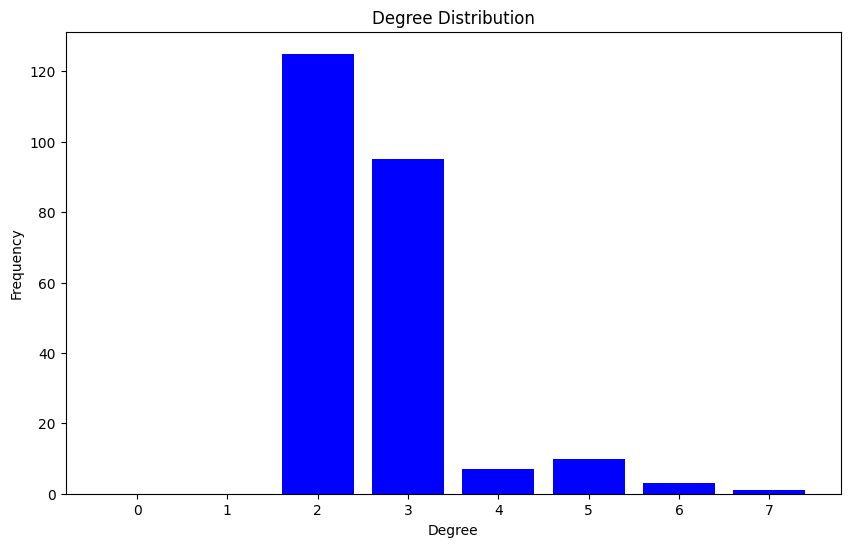

In [15]:
# compare calculated d and r values with actual values
analyze_graph(bmc_model)

In [16]:
nx.degree_assortativity_coefficient(bmc_model)

0.43695208458810253